# Week 3 - Density Based Clustering

During this weeks exercises, we will be working with density based clustering.
In particular, we will be working with the algorithms DBSCAN, DENCLUE.

First, lets import some stuff and plot the data that we are going to use today.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import sys
sys.path.append('.')
from utilities.load_data import load_iris_PC, load_t7

## Exercise 1: Theoretical questions
- Please provide a brief description of what characterises density-based clustering as a clustering approach? How do both DBSCAN and DENCLUE define clusters, and what is the core difference between the two? 

**Solution**

Desity-based clustering: clusters are density-connected points separated by sparse areas in feature space. 

Cluster: connectivity/maximality; 
Difference: 
DBSCAN: discrete kernel / counting within radius; core points.
DENCLUE: Gaussian kernel; density attractors.

## Exercise 2: DBSCAN in Action
Consider Figure 15.12 and answer the following questions, assuming that we use the
Euclidean distance between points, and that $\epsilon=2$ and $minpts = 3$
1. List all the core points.
1. Is $a$ directly density reachable from $d$?
1. Is $o$ density reachable from $i$? Show the intermediate points on the chain or the point where the chain breaks.
1. Is density reachable a symmetric relationship, that is, if $x$ is density reachable from $y$, does it imply that $y$ is density reachable from $x$? Why or why not?
1. Is $l$ density connected to $x$? Show the intermediate points that make them density connected or violate the property, respectively.
1. Is density connected a symmetric relationship?
1. Show the density-based clusters and the noise points.
1. If we use the manhattan distance instead, what is then the core points?

![15.12](graphics/15.12.png)

We have included the points in the code below, if you want to use `numpy`.

In [2]:
X = np.array([
    [5., 10., 11., 6., 10., 12., 13., 5., 10., 13., 6., 9., 11., 14., 15., 2., 3., 5., 6., 7., 15., 3., 7., 8.],
    [8.,  8.,  8., 7.,  7.,  7.,  7., 6.,  6.,  6., 5., 4.,  5.,  6.,  5., 4., 4., 4., 4., 4.,  4., 3., 3., 2.]
]).T
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']

1. $a$, $b$, $c$, $d$, $e$, $f$, $g$, $h$, $i$, $j$, $k$, $n$, $o$, $p$, $q$, $r$, $s$, $t$, $v$, $w$
2. Yes. ($d$ is a core point and $a$ is in its neighborhood.)
3. Yes, $i$->$e$->$f$->$j$->$n$->$o$.
4. No, since a non-core object may be reachable from a core object, but the reverse is not necessarily true, i.e., in the chain x = $x_0$, $x_1$, ... , $x_l$, the points $x_1$, ... , $x_l$ need to be core points but not x0. For example $u$ is density reachable from $n$ but $n$ is not density reachable from $u$.
5. Yes, $t$ is the intermediate point.
6. Yes, by definition.
7. Clusters see code and figure below. No noise points.
8. Here core points are exact the same. However, the situation would change if we change epsilon or dataset.

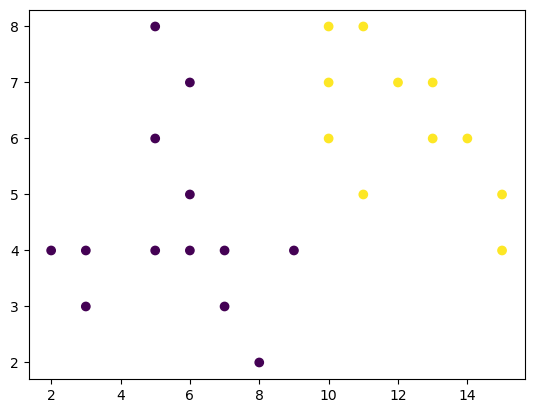

In [3]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2., min_samples=3).fit(X)
fig, ax = plt.subplots(1, 1)
ax.scatter(*(X.T), c=db.labels_)
plt.show()

## Exercise 3: Implement DBSCAN

In this exercise, we will try to implement the DBSCAN algorithm. 
You are allowed to structure your code however you want. 
The code below is inspired by [Zaki, p. 377] and serves as inspiration.

In [4]:
def L2_norm(x, y):
    return np.sqrt(np.sum((x-y)**2))

def densityConnect(x,core,cl,Nx,k): # You might need more parameters here.
    for i in Nx[x]:
        if cl[i]==-1:
            cl[i]=k
            if i in core:
                cl=densityConnect(i,core,cl,Nx,k)
    return cl


def dbscan(X, e, m, dist_fn=L2_norm):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn: Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    n=X.shape[0]
    core = []
    Nx = []
    for i in range(n):
        nx = []
        for j in range(n):
            if L2_norm(X[i],X[j]) <= e:
                nx.append(j)
        if len(nx) >= m:
            core.append(i)
        Nx.append(nx)

    clusters = np.array([-1]*n,dtype=int)
    k = 0
    for c in core:
        if clusters[c]==-1:
            clusters=densityConnect(c,core,clusters,Nx,k)
            k+=1
    
    return clusters

Here is some code to try out your implementation.
You can, of course, fiddle with the parameters and see what happens to the clusters.
The parameters provided below whould work relatively well.

C:\Users\nxghy\PycharmProjects\dm2023-exercises\exercises\utilities/data/t7-4k.txt
[ 2 -1  0 ...  1  1  8]


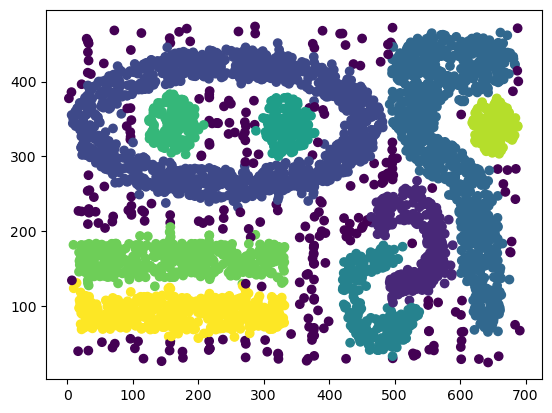

In [7]:
# Test clustering on iris_PC dataset
# clustering = dbscan(X, 0.5, 5) # Works for iris_2PC dataset
slow = True
if slow:
    X, _ = load_t7()
    clustering = dbscan(X, e=15, m=10)
    print(clustering)
else: 
    X, _ = load_iris_PC()
    clustering = dbscan(X, e=0.4, m=5)
    print(clustering)

fig, ax = plt.subplots(1, 1)
ax.scatter(*(X.T), c=clustering)
plt.show()

## Exercise 4: DENCLUE Calculations
This exercise relates to the DENCLUE algorithm introduced in Section 15.3 in [Zaki].
Consider the points shown in Figure 15.13. For the Gaussian kernel

$$
K(\mathbf{z})=\frac{1}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\mathbf{z}^{T} \mathbf{z}}{2}\right\},
$$

![](graphics/15.13.png)

answer the following questions assuming that $h = 2$:

1. What is the probability density at e?
2. What is the gradient at e? (Try to actually derive the gradient of $\hat f(x)$ your self)
3. List all the density attractors for this dataset.

As before, if you want to use `numpy`, we have included the points below.

**density estimation**

For d-dimensional data $x = (x1, ..., xd)$, the window $h$ becomes a hypercube centered at $x$ with volume $h$, that is $vol(Hd(h)) = hd$. Density estimation is the same as above, except that the density is now divided by the volume of the hypercube. Here $h=2$

$$\hat{f(e)} = \frac{1}{nh^d}\sum K(\frac{e-x}{h})$$

In [ ]:
X = np.array([
    [5., 6., 6., 2., 3., 5., 7., 9., 3., 8., 7.],
    [8., 7., 5., 4., 4., 4., 4., 4., 3., 2., 5.]
]).T
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']

#a)
n, d = X.shape

K = lambda z: np.exp(-np.dot(z, z)/2) / (2*np.pi)**(d/2)
h = 2.
e = X[4]

f_hat = np.sum([K((e-X[i])/h) for i in range(n)])  / (n*h**d)
print("f(e) = %.4f" % f_hat)

to discover "peaks", in density funtion, we compute its gradient.

$$\bigtriangledown \hat{f(e)} = \frac{1}{nh^{d+2}}\sum K(\frac{e-x}{h})\cdot(e-x)$$

In [ ]:
grad = lambda p: -np.sum([K((p-x)/h)*(p-x) for x in X], axis=0) / (n*h**(d+2))
print("f'(e) = %s" % grad(e))

**repeat**
$$X_{t+1}\gets \frac{\sum_{i}^nK(\frac{x-x_i}{h})x_i}{\sum_{i}^nK(\frac{x-x_i}{h})}$$
**until** $||x_t-x_{t-1}||< \epsilon$

In [ ]:
def gradient_ascent(p):
    old = p.copy()
    new = p.copy()
    first = True
    olds = []
    while first or np.sqrt(((old-new)**2).sum()) > 1e-6:
        olds.append(old)
        old = new
        first = False
        
        new = old + 0.3 * grad(old)
        
    return new, np.array(olds)

fig, ax = plt.subplots(1,1)
ax.scatter(*(X.T))
for x in X: 
    attractor, path = gradient_ascent(x)
    print(attractor, x)
    ax.plot(*(path.T))
plt.savefig('density-attractor.png')
plt.show()


## Exercise 5: Contingency table 

Provide an implementation of the contingency table and plot the table varying the DBScan parameters. Use iris_pc dataset. 
1. Can you use the contingengy table to evaluate the quality of clustering? 
2. Can you compute purity based on the contingency table?
3. Can you find the best parameter setting using purity?

In [ ]:
X,ground_truth = load_iris_PC()
n=ground_truth.shape[0]
from sklearn.cluster import DBSCAN

def convert(Y): # convert nxc one-hot matrix to nx1 vector
    res=np.ndarray(Y.shape[0])
    for i in range(Y.shape[0]):
        res[i]=np.where(Y[i]==1)[0]
    return res

ground_truth=convert(ground_truth)

**Contingency table**

$$N_{ij} = n_{ij} = |C_i\cap T_j|$$

In [ ]:
def contingency_table(C, T): 
    """
    Args:
        C:       Clusters obtained by a clustering algorithm as a nx1 vector
        T:       Ground-truth cluster assignments as a nx1 vector

    Returns:
        ctable:   a num_clusters_of_C x num_cluster_of_T matrix containing the overlaps among the different clusters
    """
    
    ctable = np.zeros([int(np.max(C))+1,int(np.max(T))+1],dtype=int)
    n = len(C)
    for i in range(n):
        if (C[i]>=0):
            ctable[int(C[i]),int(T[i])]+=1
            
    return ctable


**purity**

$$purity_i = \frac{1}{|C_i|}max_{j=1..k}\{n_{ij}\}$$

In [ ]:
def purity(ctable,n):
    """
    Args:
        ctable:   a num_clusters_of_C x num_cluster_of_T matrix containing the overlaps among the different clusters

    Returns:
        purity:   a float, the purity of clustering result
    """
    purity = 0.0
    w=ctable.max(1)
    purity=np.sum(w)/n
    return purity


In [ ]:
eps_lst = np.linspace(0.1, 1, 19) #[0.1,0.15,...,1] for eps
minpts_lst = np.linspace(2, 15, 14) #[2,3,...,15] for minpts
purity_table = np.zeros((len(eps_lst), len(minpts_lst)))

for i in range(len(eps_lst)):
    for j in range(len(minpts_lst)):
        cl = dbscan(X,eps_lst[i], minpts_lst[j]) #use your dbscan
        ctable = contingency_table(cl, ground_truth) #use your contingency table function above
        prt = purity(ctable, n) #use your purity function above
        purity_table[i, j] = prt
print(purity_table) #purity with different parameters


In [ ]:
import pandas as pd

df = pd.DataFrame(purity_table)
display(df)
best = np.unravel_index(np.argmax(purity_table, axis = None), purity_table.shape)
print(f"Best parameter setting is: {best},\nThe maximal purity is: {purity_table[best]}")

## Exercise 6: DBSCAN with Gaussian kernel

In this exercise, we are going to alter the DBSCAN algorithm to use another kernel.

As stated in [Zaki, p.388], DBSCAN is a special case of DENCLUE.
In particular, if we let $h=\epsilon$ and $\xi = minPts$ with a discrete kernel, then the two algorithms will yield the same result.

We are now going to go a step in the other direction.
Thas is, we will add a Gaussian kernel to the DBSCAN algorithm.
The Gaussian kernel is defined as in Equation (1).

$$
K(\mathbf{z})=\frac{1}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\mathbf{z}^{T} \mathbf{z}}{2}\right\}
\qquad \qquad (1)
$$

The implications in terms of the algorithm are the following:

1. When selecting core points, they are now going to depend on a threshold $\xi$ of the density estimates $\hat f(x)$.
2. The threshold $\epsilon$ is now going to be compared against $K(\frac{x-x_i}{h})$ when calculating neighborhoods and density connectedness.
3. The value $h$ which was previously fixed to $\epsilon$ is now going to be a parameter to the model.

As before, the code below serves as inspiration.

In [ ]:
def K(z):
    return  np.exp(-np.dot(z, z)/2) / np.sqrt(2*np.pi)

def densityConnect(x,core,cl,Nx,k): # You might need more parameters here.
    for i in Nx[x]:
        if cl[i]==-1:
            cl[i]=k
            if i in core:
                cl=densityConnect(i,core,cl,Nx,k)
    return cl

def gaussian_dbscan(X, e, m, h):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn: Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    # TODO, code here.
    n=X.shape[0]
    core = []
    Nx = []
    for i in range(n):
        d = 0
        nx = []
        for j in range(n):
            dj=K((X[i]-X[j])/h)/n*h**d
            if dj >= e and i != j:
                nx.append(j)
            d+=dj
        Nx.append(nx)
        if d>=m:
            core.append(i)
    clusters = np.array([-1]*n,dtype=int)
    k=0
    for c in core:
        if clusters[c]==-1:
            clusters=densityConnect(c,core,clusters,Nx,k)
            k+=1
    
    return clusters


You can use the code below to run your algorithm.

In [ ]:
# Test clustering on iris_PC dataset
np.random.seed(0)

slow = True
if slow:
    X, _ = load_t7()
    n, _ = X.shape
    X = X[np.random.permutation(n)]
    X = X[:2000]
    clustering = gaussian_dbscan(X, e=0.00000006, m=0.00018, h=3.25)
else: 
    X, _ = load_iris_PC()
    clustering = gaussian_dbscan(X, e=0.2, m=12., h=0.7)

fig, ax = plt.subplots(1, 1)
sc = ax.scatter(*(X[clustering >= 0].T), c=clustering[clustering>=0])
sc = ax.scatter(*(X[clustering < 0].T), marker='x')
plt.colorbar(sc)
plt.show()

## Exercise 7: Comparing the DBSCAN versions above
Please describe how the two versions of DBSCAN above differ.
How do you think the the differences affects the clustering of the data?

Did you see any practical differences in the "experiments" above?